This model (Customer personality analysis) helps a business to modify its product based on its target customers from different types of customer segments. For example, instead of spending money to market a new product to every customer in the company’s database, a company can analyze which customer segment is most likely to buy the product and then market the product only on that particular segment.

In [98]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [99]:
df = pd.read_csv('./data/marketing_campaign.csv', sep='\t')
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


In [100]:
df.isnull().sum()

# Since there are not many null, we can get rid of them
df.dropna(inplace=True)

In [101]:
# There are no duplicated values
df[df.duplicated()]

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response


### Distribution Analysis

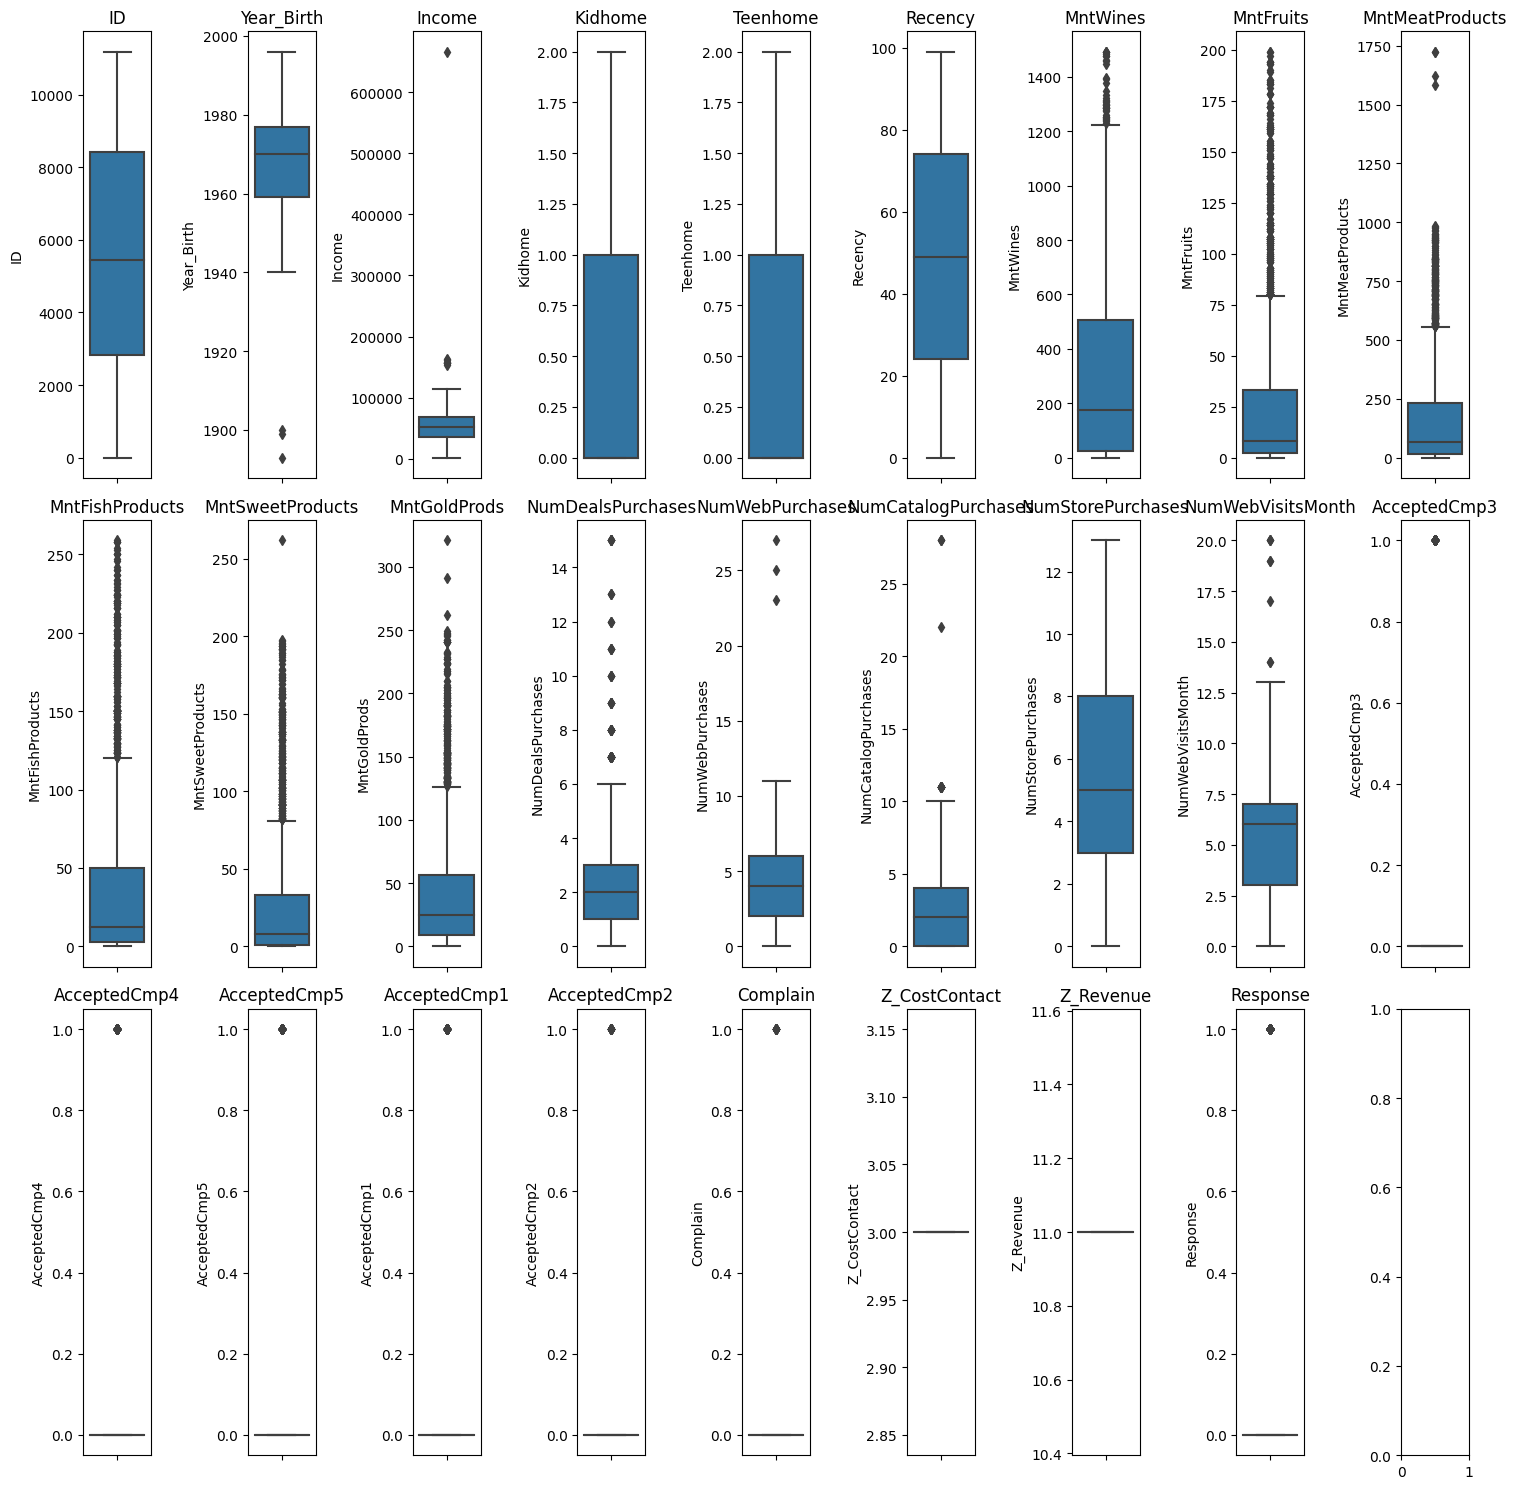

In [102]:
int_cols = df.select_dtypes(exclude='object').columns
num_plots = len(int_cols)
rows = 3  # Número de filas deseadas
cols = num_plots // rows + (num_plots % rows > 0)  # Número de columnas deseadas

fig, axes = plt.subplots(rows, cols, figsize=(15, 15))  # Ajusta el tamaño de la figura según tus necesidades

for i, col in enumerate(int_cols):
    ax = axes[i // cols, i % cols] if rows > 1 else axes[i % cols]  # Obtén el eje correspondiente
    sns.boxplot(data=df, y=col, ax=ax)
    ax.set_title(col)  # Opcional: establece el título de cada gráfico

plt.tight_layout()  # Ajusta el espaciado entre los gráficos
plt.show()

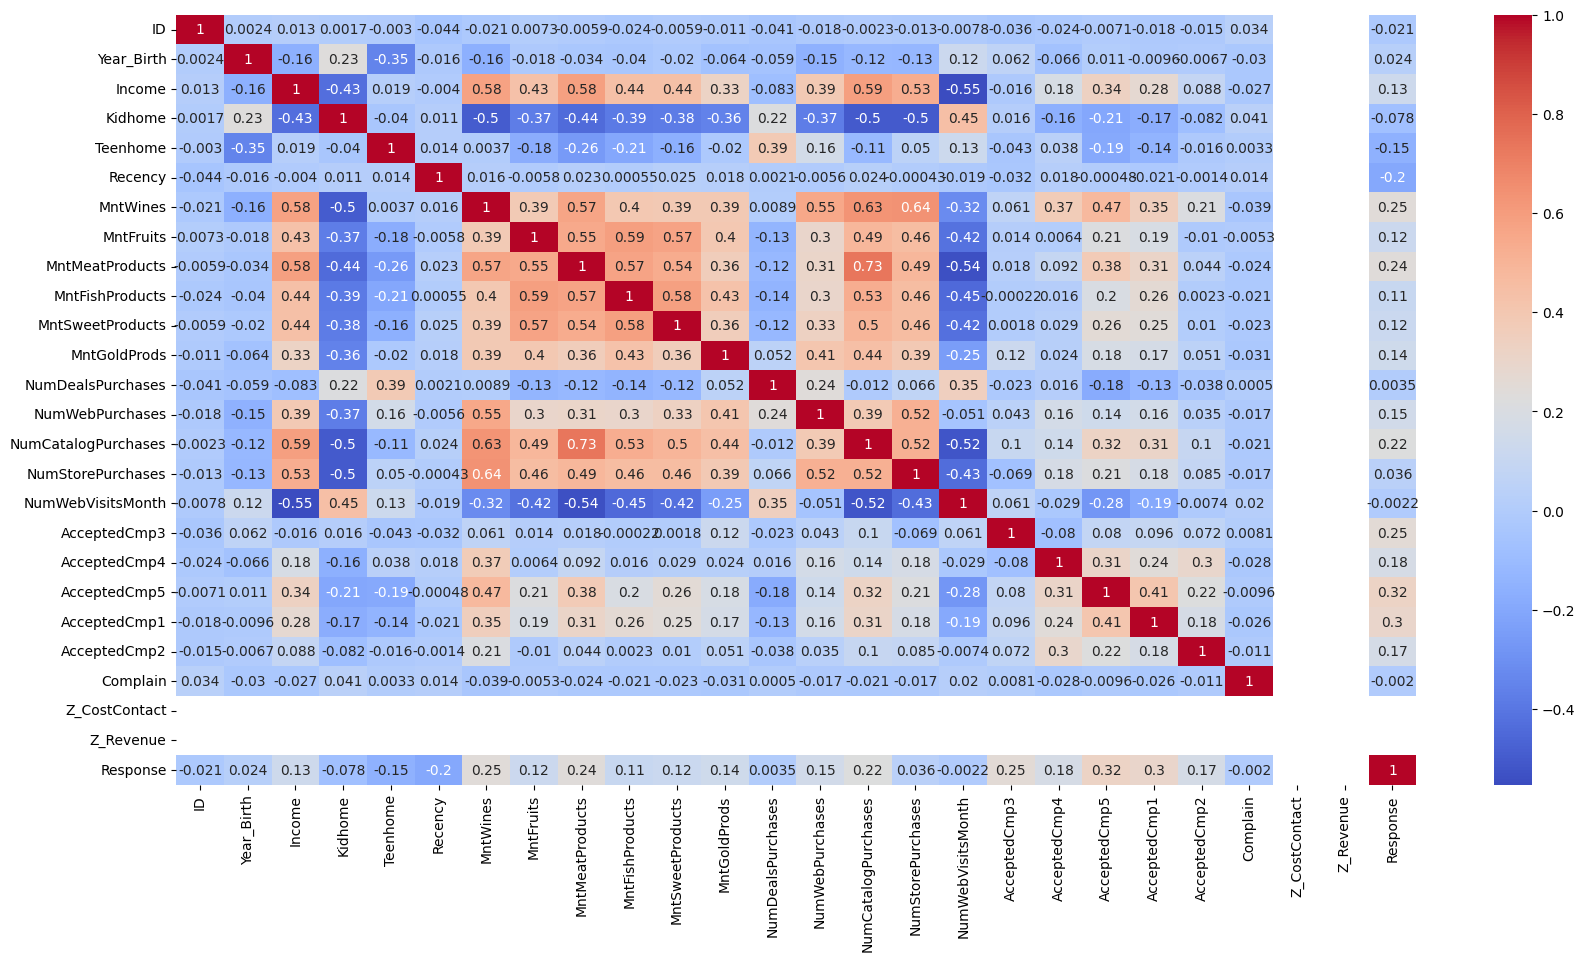

In [103]:
# Compute correlation matrix
corr = df[int_cols].corr()

fig = plt.figure(figsize=(20,10))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

### Scaling data

In [104]:
# Removing categorical data
df_int_cols = df.select_dtypes(exclude='object')

In [105]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

df_scaled = scaler.fit_transform(df_int_cols.drop(['ID', 'Z_CostContact', 'Z_Revenue'], axis=1))


### PCA

In [106]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit_transform(df_scaled)
pca_data_scaled = pca.transform(df_scaled)
pca_data_scaled

array([[ 3.77060179, -0.05660085, -0.31451879, ..., -0.16403389,
        -0.72465474,  0.20355093],
       [-2.38183938,  0.21417804, -0.20581445, ..., -0.18702504,
        -0.114473  , -0.03190478],
       [ 1.61778854,  0.1322056 , -1.05246313, ..., -0.03099445,
        -0.13402577,  0.0659859 ],
       ...,
       [ 1.46380237, -0.01480533,  0.95776498, ...,  0.9400841 ,
         0.06390013,  0.05377127],
       [ 1.75419408,  1.34776544, -0.98283731, ..., -0.31495736,
        -0.08954561,  0.36822286],
       [-1.68676175,  0.66106694,  1.1511857 , ...,  0.15513097,
         0.07005939,  0.28277964]])

In [107]:
# Variance depending on the number of components

# Each number represents a number of components in asceding order
var = pca.explained_variance_ratio_
print(var)

[0.28443482 0.08841178 0.08273063 0.06094254 0.04774546 0.04445952
 0.04279366 0.03722617 0.0329627  0.03226928 0.02865239 0.02665154
 0.02532829 0.02447454 0.0225929  0.0201354  0.01857836 0.01779583
 0.01633907 0.01378428 0.01299043 0.01019744 0.00850299]


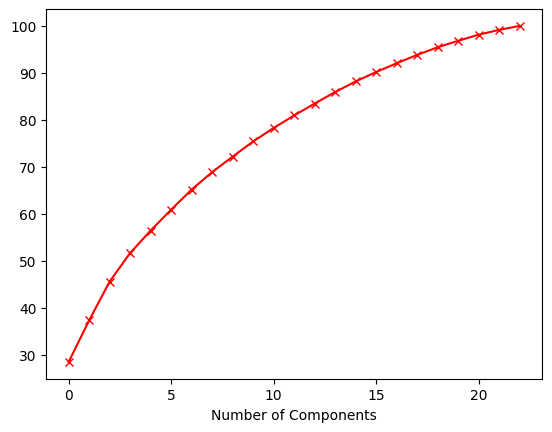

In [108]:
cum_var = np.cumsum(np.round(var, decimals=4)*100)
plt.plot(cum_var, 'r-x')
plt.xlabel('Number of Components')
plt.show()

In [109]:
# Since the purpose of this is to reduce our dimensionality, we're going to stick with 4 components
pca_data_standard = pd.DataFrame(pca_data_scaled)
# I am going to drop these, since we're already going to use the first 4
pca_data_standard.drop([19,20,21,22], axis=1, inplace=True)

### Using KMeans

In [110]:
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage

sum_of_squared_distances = []
silhouette_scores= []

K = range(2, 15)

for _ in K:
    km = KMeans(n_clusters=_)
    y = km.fit_predict(pca_data_standard)
    sum_of_squared_distances.append(km.inertia_)
    silhouette_scores.append(silhouette_score(pca_data_standard, y))

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.1

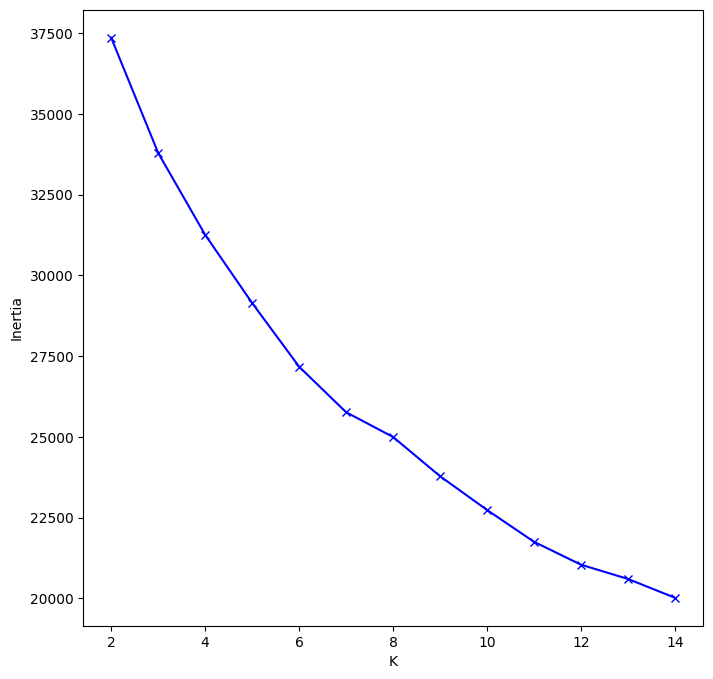

In [111]:
plt.figure(figsize=(8,8))
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('K')
plt.ylabel('Inertia')
plt.show()

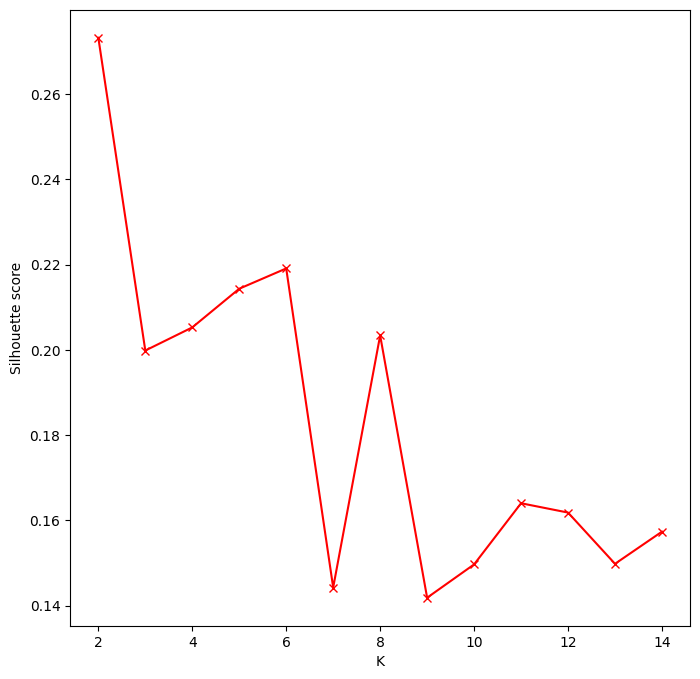

In [112]:
plt.figure(figsize=(8,8))
plt.plot(K, silhouette_scores, 'rx-')
plt.xlabel('K')
plt.ylabel('Silhouette score')
plt.show()

In [113]:
km = KMeans(n_clusters=4)
y = km.fit_predict(pca_data_standard)
df['k_means_pca'] = y

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [114]:
print(silhouette_score(pca_data_standard, y))

0.2052268948225986


### Not PCA

In [115]:
sum_of_squared_distances = []
silhouette_scores= []

K = range(2, 15)

for _ in K:
    km = KMeans(n_clusters=_)
    y = km.fit_predict(df_scaled)
    sum_of_squared_distances.append(km.inertia_)
    silhouette_scores.append(silhouette_score(df_scaled, y))

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.1

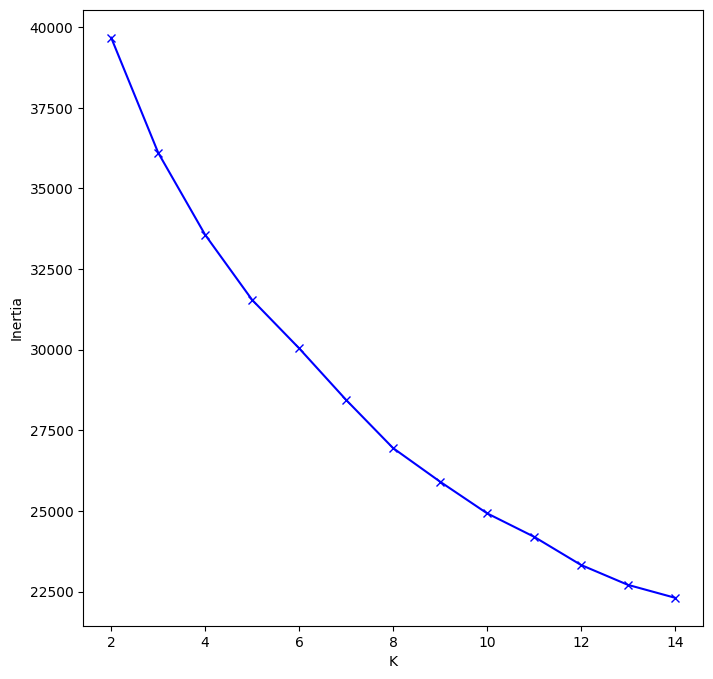

In [116]:
plt.figure(figsize=(8,8))
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('K')
plt.ylabel('Inertia')
plt.show()

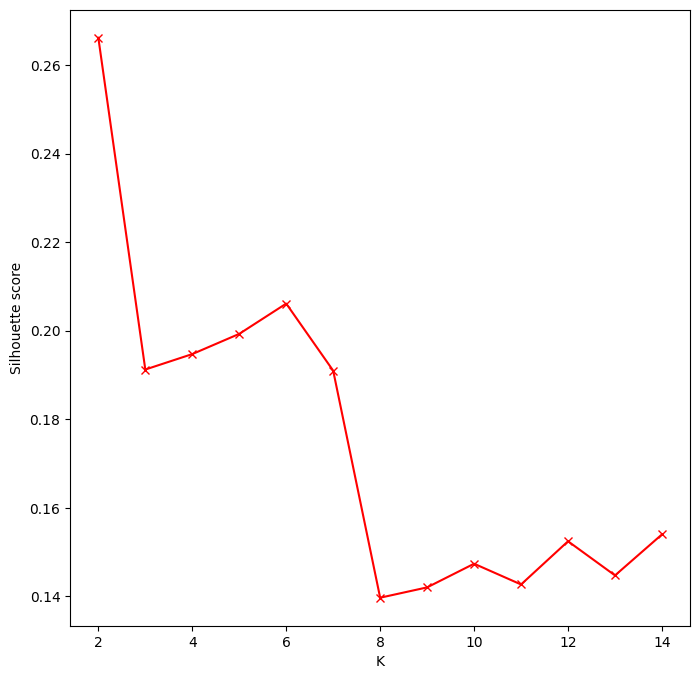

In [117]:
plt.figure(figsize=(8,8))
plt.plot(K, silhouette_scores, 'rx-')
plt.xlabel('K')
plt.ylabel('Silhouette score')
plt.show()

In [118]:
km = KMeans(n_clusters=5)
y = km.fit_predict(df_scaled)
df['k_means'] = y

print(silhouette_score(df_scaled, y))

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


0.20006498077430582


### Agglomerative hierarchical clustering

### PCA

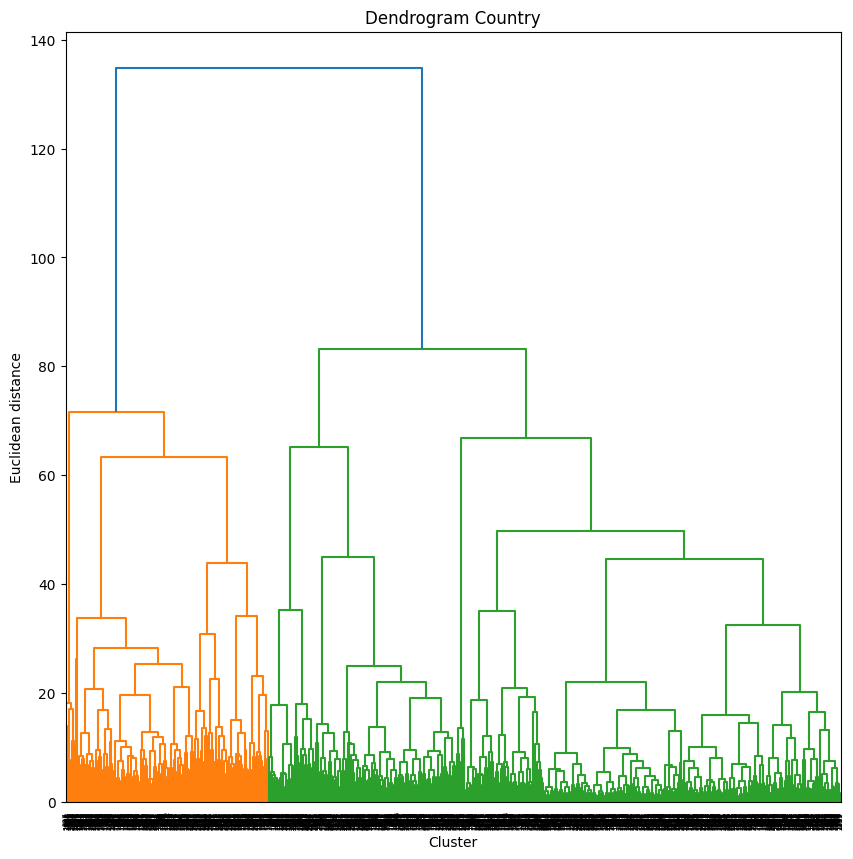

In [119]:
fig = plt.figure(figsize=(10, 10))
dendrogram_plot = dendrogram(linkage(pca_data_standard, method='ward'))
plt.title('Dendrogram Country')
plt.xlabel('Cluster')
plt.ylabel('Euclidean distance')
plt.show()

In [120]:
hc = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')
y_hc = hc.fit_predict(pca_data_standard)
df['hc_pca'] = y_hc

print(silhouette_score(pca_data_standard, y_hc))

0.2807691142064829


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


### Not PCA

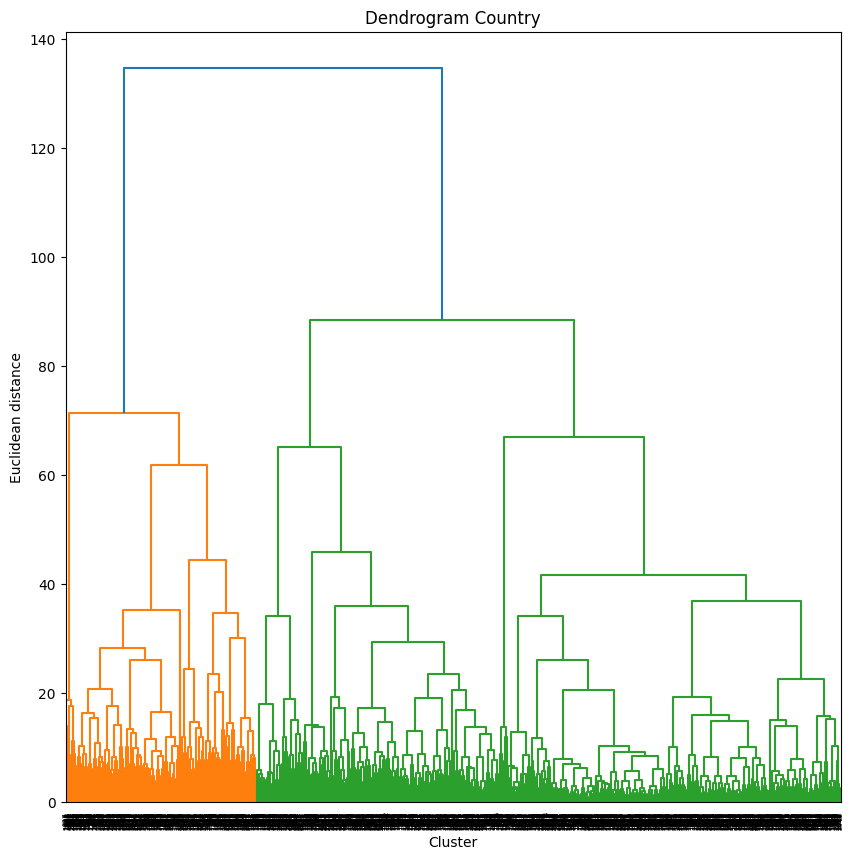

In [121]:
fig = plt.figure(figsize=(10, 10))
dendrogram_plot = dendrogram(linkage(df_scaled, method='ward'))
plt.title('Dendrogram Country')
plt.xlabel('Cluster')
plt.ylabel('Euclidean distance')
plt.show()

In [122]:
hc = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')
y_hc = hc.fit_predict(df_scaled)
df['hc'] = y_hc

print(silhouette_score(df_scaled, y_hc))

0.2851451480362329


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


### Using DBScan

In [123]:
from sklearn.neighbors import NearestNeighbors
neighbors = NearestNeighbors(n_neighbors=2)
neighbors_fit = neighbors.fit(pca_data_standard)
distances, index = neighbors_fit.kneighbors(pca_data_standard)

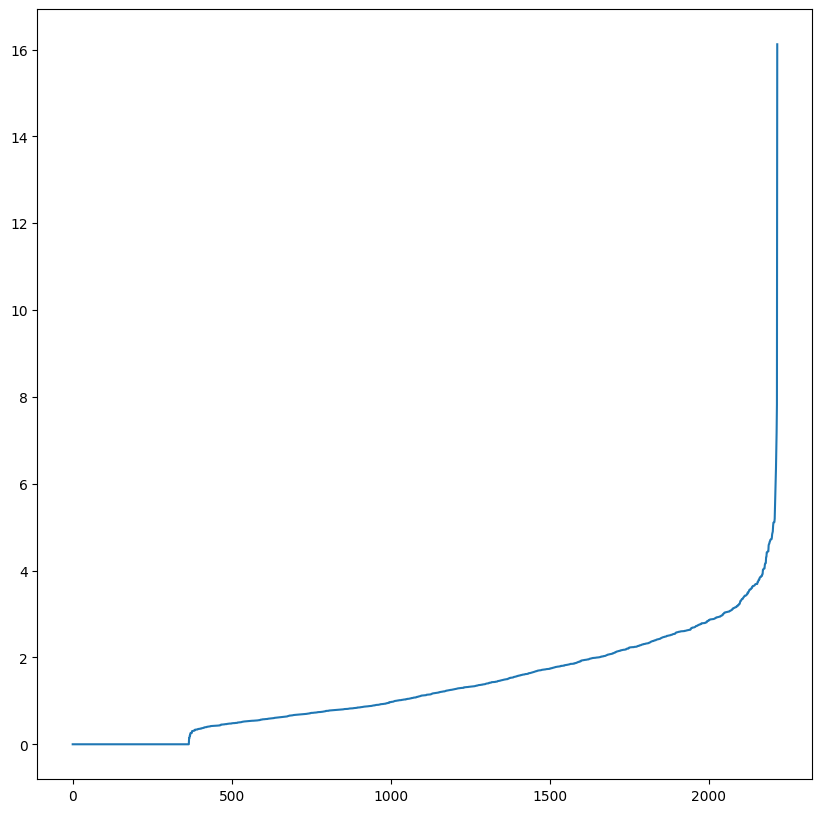

In [124]:
distances = np.sort(distances, axis=0)
distances = distances[:,1]
fit = plt.figure(figsize=(10,10))
plt.plot(distances)

# Our knee is between 2 and 3.5

In [125]:
eps_values = np.arange(2, 3.5, 0.1)
min_samples = np.arange(3, 12)

In [126]:
from itertools import product 
dbscan_params = list(product(eps_values, min_samples))
no_clusters = []
sil_score = []

for p in dbscan_params:
    y_dbscan = DBSCAN(eps=p[0], min_samples=p[1]).fit_predict(pca_data_standard)
    try:
        sil_score.append(silhouette_score(pca_data_standard, y_dbscan))
    except:
        sil_score.append(0)

    no_clusters.append(len(np.unique(y_dbscan)))

In [127]:
df_param_tuning = pd.DataFrame.from_records(
    dbscan_params, columns=['eps', 'min_samples']
)

df_param_tuning['sil_score'] = sil_score
df_param_tuning['no_clusters'] = no_clusters

In [128]:
pivot_1 = pd.pivot_table(df_param_tuning, values='sil_score', columns='eps', index='min_samples')
pivot_2 = pd.pivot_table(df_param_tuning, values='no_clusters', columns='eps', index='min_samples')

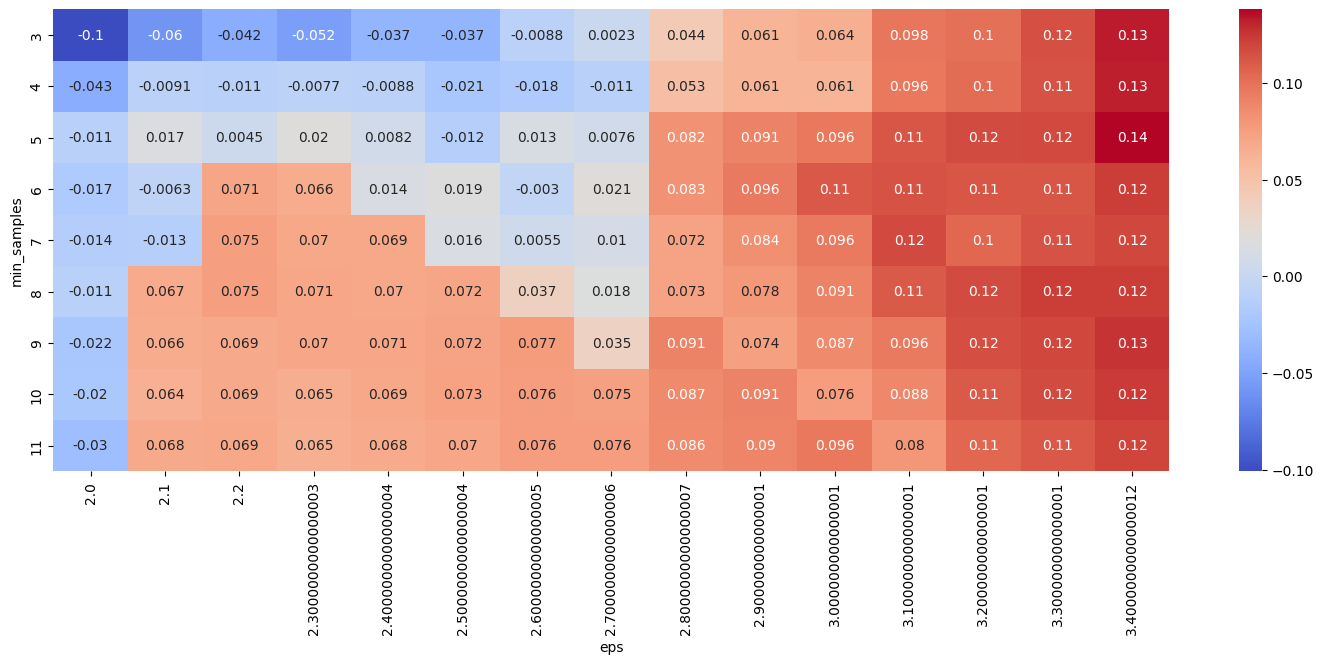

In [129]:
fig, ax = plt.subplots(figsize=(18,6))
sns.heatmap(pivot_1, annot=True, annot_kws={'size':10}, cmap='coolwarm', ax=ax)
plt.show()

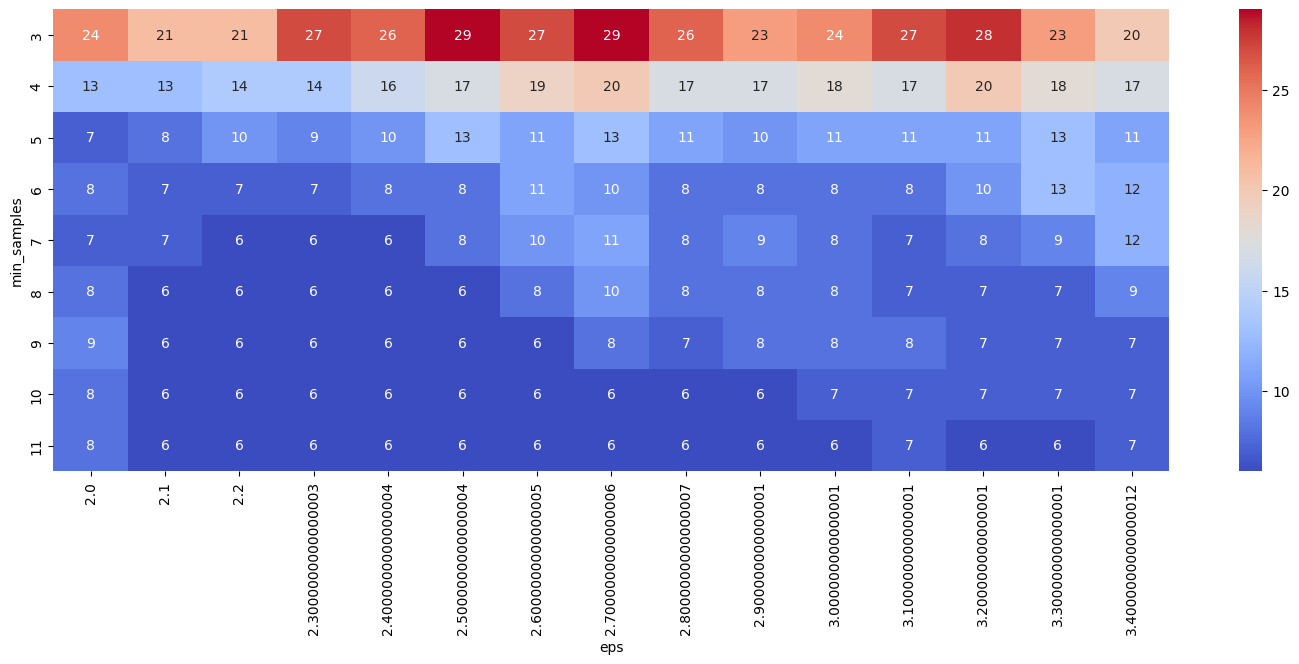

In [130]:
fig, ax = plt.subplots(figsize=(18,6))
sns.heatmap(pivot_2, annot=True, annot_kws={'size':10}, cmap='coolwarm', ax=ax)
plt.show()

In [164]:
dbscan_train = DBSCAN(eps=12, min_samples=3)
y_dbscan = dbscan_train.fit_predict(pca_data_standard)
df['dbscan_pca'] = y_dbscan

print(silhouette_score(pca_data_standard, y_dbscan))

0.7057516536409337
